Import library


In [1]:
import pandas as pd
import glob
from PIL import Image
from IPython.display import display
import seaborn as sns
from keras_preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [13]:
train_data_path='data\\bali-26_train\\bali-26_train'
split_symbol='\\'

validation_split = 0.2
image_width = image_height = 224
num_of_class=26

# Data prepare

Load data, convert to pandas

In [14]:
data=[]
for folder_path in glob.glob(f'{train_data_path}{split_symbol}*'):
    label=folder_path.split(split_symbol)[-1]
    for file_path in glob.glob(f'{folder_path}{split_symbol}*.jpg'):
#         size = img=Image.open(file_path).size
        size = (1)
        data.append([file_path,label,size])
df = pd.DataFrame(columns=['filepath', 'label','img_size'], data=data)
df.to_csv('bali-26_train.csv',index=False)
df.head()

,filepath,label,img_size
0,data\bali-26_train\bali-26_train\bamboo\1.jpg,bamboo,1
1,data\bali-26_train\bali-26_train\bamboo\10.jpg,bamboo,1
2,data\bali-26_train\bali-26_train\bamboo\100.jpg,bamboo,1
3,data\bali-26_train\bali-26_train\bamboo\1000.jpg,bamboo,1
4,data\bali-26_train\bali-26_train\bamboo\1001.jpg,bamboo,1


Preview data

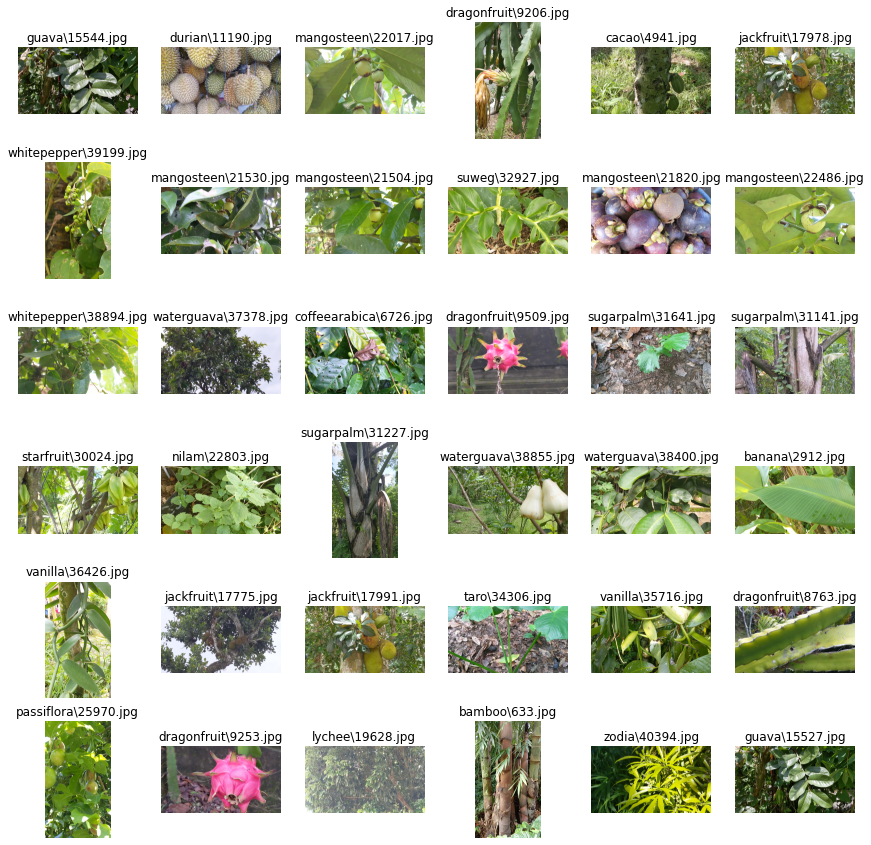

In [15]:
w = 6
h = 6
_, axes_list = plt.subplots(h, w, figsize=(2.5*w, 2.5*h))
for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_row = np.random.choice(df.index)
        img = Image.open(df.loc[random_row,'filepath'])
        ax.imshow(img) # load and show
        title = split_symbol.join(df.loc[random_row,'filepath'].split(split_symbol)[-2:])
        ax.set_title(title)
plt.show()

Show label distribution

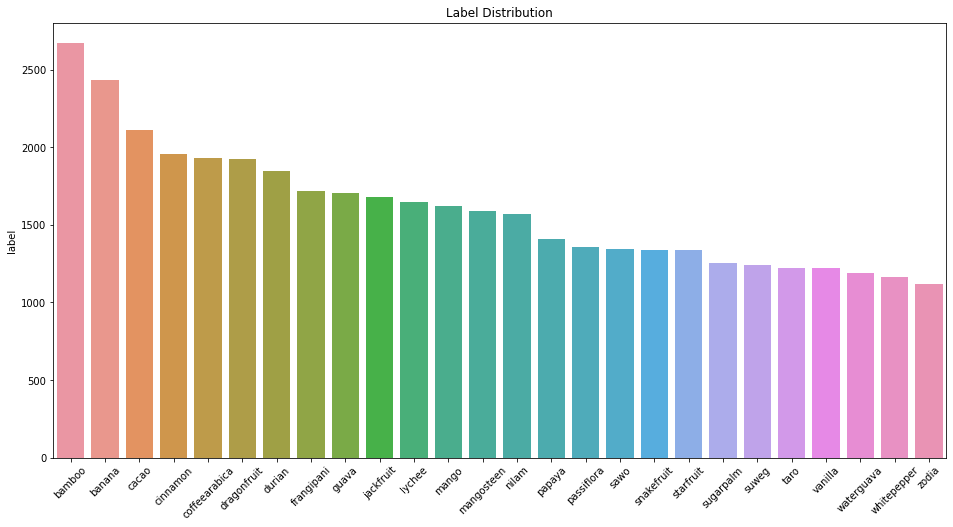

In [16]:
fig = plt.figure(figsize=(16,8))
# plt.bar(df.label.unique(), df.label.value_counts())
sns.barplot(x=df.label.unique(), y=df.label.value_counts())
plt.xticks(rotation=45)
plt.title('Label Distribution')
plt.show()

Show image size distribution

In [ ]:
plt.pie(df['img_size'].value_counts(), labels=df['img_size'].unique(), autopct='%1.1f%%')
plt.title('Image size Distribution')
plt.show()

# Training model

In [19]:
datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range=0.2,
                            zoom_range=0.2,
                            rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            validation_split=validation_split)


In [20]:
train_it = datagen.flow_from_directory(train_data_path,
                                       class_mode='categorical',
                                       batch_size=64,
                                       target_size=(image_width, image_height),
                                       subset='training',
                                       )
valid_it = datagen.flow_from_directory(train_data_path,
                                       class_mode='categorical',
                                       batch_size=64,
                                       target_size=(image_width, image_height),
                                       subset='validation',
                                       )


Found 33295 images belonging to 26 classes.
Found 8312 images belonging to 26 classes.


In [29]:
import keras.backend as K
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=True,
    weights=None,
    input_shape=( image_width, image_height  , 3),
    classes=num_of_class,
    classifier_activation='softmax',
)
    
model.compile(optimizer ="adam",                
              loss='categorical_crossentropy', 
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),f1_metric ])

In [24]:
checkpoint_path = "./train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks=[
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,verbose=1,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1, min_lr=0.00001)
]

In [28]:
history  =  model.fit(train_it, 
          epochs= 2,
          validation_data=valid_it,
          callbacks= callbacks)

Epoch 1/2


KeyboardInterrupt: 

In [ ]:
# summarize history 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig=plt.figure(figsize=(8, 8))
fig.set_size_inches(18.5, 10.5)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Submission

In [ ]:
labels = (train_it.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [ ]:
# predict the test for submission
folder_path='../input/classification-of-plants-of-southeast-asia/bali-26_test/bali-26_test'
images= glob.glob('{}/*.jpg'.format(folder_path))
submissions=[]

for image_file in images:
    img = image.load_img(image_file, target_size=(image_height, image_width))
    x = image.img_to_array(img)
    x = x / 255.0
    x = x.reshape((1,)+x.shape)
    predict=model.predict(x)[0]
    
    idd=image_file.split('/')[-1]
    category=labels[np.argmax(predict)]
    submissions.append([idd,category])
df = pd.DataFrame(columns=['id', 'category'], data=submissions)
df.to_csv('submission.csv',index=False)
df.head()